In [13]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, logging
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
import shutil
import matplotlib.pyplot as plt

In [14]:
logging.set_verbosity_error()

In [15]:
MODEL_DIR = "models/roberta-toxic"
MODEL_NAME = "roberta-base"

train_df = pd.read_csv("data/preprocessed/clean_train.csv", sep=";")
test_df = pd.read_csv("data/preprocessed/clean_test.csv", sep=";")
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
BATCH_SIZE = 8
EPOCHS = 3
LR = 1e-5

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(example):
    return tokenizer(example["message"], padding="max_length", truncation=True, max_length=128)
train_enc = train_dataset.map(tokenize_function, batched=True)
test_enc = test_dataset.map(tokenize_function, batched=True)
train_enc.set_format("torch", columns=["input_ids", "attention_mask", "is_toxic"])
test_enc.set_format("torch", columns=["input_ids", "attention_mask", "is_toxic"])

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)

Используем устройство: cuda


In [19]:
if os.path.exists(MODEL_DIR):
    print("Найдена сохранённая модель, загружаем...")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
else:
    print("Сохранённая модель не найдена, создаём новую и обучаем...")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)
    train_loader = DataLoader(train_enc, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=LR)
    loss_fn = torch.nn.CrossEntropyLoss()
    shutil.rmtree(MODEL_DIR, ignore_errors=True)
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        for batch in loop:
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != "is_toxic"}
            labels = batch["is_toxic"].to(device)
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Средняя потеря за эпоху {epoch + 1}: {total_loss / len(train_loader):.4f}")
    model.save_pretrained(MODEL_DIR)
    tokenizer.save_pretrained(MODEL_DIR)
    print("\nМодель и токенизатор сохранены в", MODEL_DIR)


Найдена сохранённая модель, загружаем...


In [20]:
model.to(device)
model.eval()
test_loader = DataLoader(test_enc, batch_size=BATCH_SIZE)
preds, labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Оценка"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "is_toxic"}
        y_true = batch["is_toxic"].to(device)
        outputs = model(**inputs)
        y_pred = torch.argmax(outputs.logits, dim=1)
        preds.extend(y_pred.cpu().numpy())
        labels.extend(y_true.cpu().numpy())

Оценка:   0%|          | 0/29 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.955     0.899     0.926       119
           1      0.897     0.954     0.924       109

    accuracy                          0.925       228
   macro avg      0.926     0.927     0.925       228
weighted avg      0.927     0.925     0.925       228

F1-score: 0.924


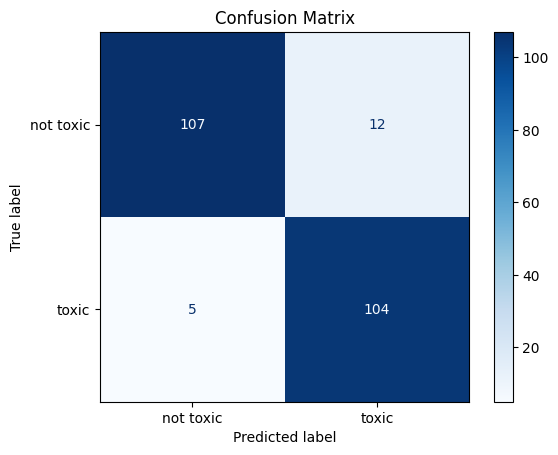

In [21]:
print(classification_report(labels, preds, digits=3))
print("F1-score:", round(f1_score(labels, preds), 3))
cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm, display_labels=["not toxic", "toxic"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [22]:
classifier_weights = model.classifier.state_dict()["out_proj.weight"].detach().cpu().numpy()
classifier_bias = model.classifier.state_dict()["out_proj.bias"].detach().cpu().numpy()
top_toxic_idx = np.argsort(classifier_weights[1])[-15:][::-1]
top_nontoxic_idx = np.argsort(classifier_weights[1])[:15]
vocab = list(tokenizer.get_vocab().keys())

In [23]:
print("Топ токсичных токенов:")
for idx in top_toxic_idx:
    print(f"{vocab[idx]:<20} {classifier_weights[1][idx]:.3f}")


Топ токсичных токенов:
Ġsperm               0.049
Ġjohn                0.046
Ġcollaborator        0.041
Ġconsolation         0.041
Ġprediction          0.041
atical               0.040
UTION                0.039
Ġlob                 0.039
ĠPolaris             0.039
ĠCork                0.038
ĠHO                  0.037
Ġdepicted            0.037
ĠHanson              0.036
Ġentropy             0.035
ĠLisbon              0.033


In [24]:
print("Топ нетоксичных токенов:")
for idx in top_nontoxic_idx:
    print(f"{vocab[idx]:<20} {classifier_weights[1][idx]:.3f}")


Топ нетоксичных токенов:
acus                 -0.050
ĠMarvel              -0.046
Ġvulgar              -0.044
Ġdefiant             -0.042
Ġsystem              -0.042
Ent                  -0.042
û                    -0.042
Ġphotographed        -0.041
Ġlocal               -0.041
514                  -0.040
Seven                -0.040
Ġ00000000            -0.040
Ġdespair             -0.039
Ġinstitution         -0.037
ĠSa                  -0.037
